# Unit 2 - Cost of Test

Group members:

- Ole Magnus Laerum
- Piotr Franc

## Task Description
Consider the dataset Breastcancer with the following partition tr/test. Consider the test costs for each attribute given by the array testcosts (the first position of the array corresponds to the first attribute, CL.thickness, the second to Cell.size..). Consider also misclassification costs where the cost of predicting “benign” when the actual class is “malignant” is 20. The cost of predicting “malignant” when the actual class is “benign” is 4. Hits cost 0.

Try to minimise the global cost of your model. Draw a plot of test cost versus missclassification cost of the different options explored.

In [41]:
library(caret)

library(mlbench)
data(BreastCancer)
BreastCancer<-BreastCancer[,-1]
set.seed(480)
BreastCancer<-BreastCancer[complete.cases(BreastCancer),]
hv_index <- createDataPartition(BreastCancer$Class, p = .75, list = FALSE)
train <- BreastCancer[ hv_index, ]
test <- BreastCancer[-hv_index, ]
testscosts<-c(2,4,3,1,5,3,2,4,2,0)  
cost_FP = 4
cost_FN = 20

## Part 1 - Find the promising attributes

In [42]:
create_model <- function(selected_indices) {
    selected_attributes <- names(BreastCancer)[selected_indices]
    formula <- as.formula(paste("Class ~", paste(selected_attributes, collapse = " + ")))

    model <- train(formula, 
               data = train, 
               method = "rf", 
               verbose = FALSE, 
               trControl = trainControl(method = "none"))
    return(model)
}

get_costs <- function(selected_indices){
    model <- create_model(selected_indices)
    
    pred_probs <- predict(model, test, type = "prob")
    threshold <- 0.1
    preds <- factor(ifelse(pred_probs[, "malignant"] > threshold, "malignant", "benign"),
                levels = levels(test$Class))
    cm <- confusionMatrix(preds, test$Class)
    # print(cm$table)
    costs <- list()  

    attributes_weights <- rep(0, length(testscosts))  
    attributes_weights[selected_indices] <- 1  

    FN = cm$table["benign", "malignant"]
    FP = cm$table["malignant", "benign"]
    
    costs$errors_cost <- FN * cost_FN + FP * cost_FP
    costs$tests_cost <- nrow(test) * sum(testscosts * attributes_weights)
    # costs$tests_cost <-  sum(testscosts * attributes_weights)
    costs$total_cost <- costs$tests_cost + costs$errors_cost

    return(costs)
}

In [43]:
attrs_results = list()

cat("Id   Attribute  \ttotal_cost\terrors_cost\ttests_cost\n")
for (i in 1:9) {
    attrs = c(i)
    costs = get_costs(attrs)

    attr_name = names(BreastCancer)[attrs]

    attrs_results[[i]] <- list(
        errors_cost = costs$errors_cost,
        tests_cost = costs$tests_cost,
        total_cost = costs$total_cost
    )

    cat(sprintf("%-3d %-20s %10d %10d %10d\n", i, attr_name, costs$total_cost, costs$errors_cost, costs$tests_cost))
}   

Id   Attribute  	total_cost	errors_cost	tests_cost
1   Cl.thickness                780        440        340
2   Cell.size                   768         88        680
3   Cell.shape                  710        200        510
4   Marg.adhesion               422        252        170
5   Epith.c.size               1010        160        850
6   Bare.nuclei                 658        148        510
7   Bl.cromatin                 564        224        340
8   Normal.nucleoli             944        264        680
9   Mitoses                     996        656        340


### Takeaways
As we see, Marg.adhesion has a total cost of 422, 170 of which comes from the tests. 

We can notice that when we try to add any other attribute the cost of tests will already outweight the total cost of this model, which means that this is the global minimum

## Part 2 - Trying to find the minimum for Tests Costs
Since the global minimum is achieved using a single attribute, we aim to analyze the relationship between test costs and misclassification costs. To achieve this, we will evaluate the model’s performance using subsets of attributes ranging from 1 to 9.

Selected Attributes: Marg.adhesion 
Selected Attributes: Marg.adhesion Bl.cromatin 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei Cell.shape 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei Cell.shape Cell.size 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei Cell.shape Cell.size Cl.thickness 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei Cell.shape Cell.size Cl.thickness Normal.nucleoli 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei Cell.shape Cell.size Cl.thickness Normal.nucleoli Mitoses 
Selected Attributes: Marg.adhesion Bl.cromatin Bare.nuclei Cell.shape Cell.size Cl.thickness Normal.nucleoli Mitoses Epith.c.size 


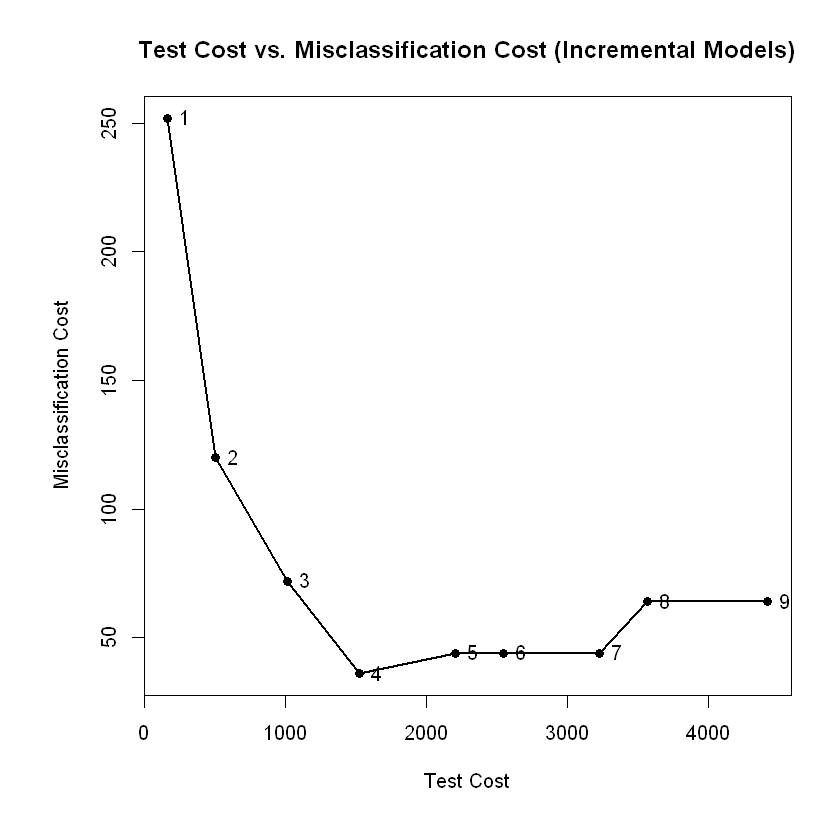

In [46]:
df <- data.frame(
    Id = 1:9,
    Attribute = sapply(1:9, function(i) names(BreastCancer)[i]),
    Errors_Cost = sapply(attrs_results, function(x) x$errors_cost),
    Tests_Cost = sapply(attrs_results, function(x) x$tests_cost),
    Total_Cost = sapply(attrs_results, function(x) x$total_cost)
)

# Sort by Total Cost
df_best <- df[order(df$Total_Cost), ]

cumulative_errors <- c()
cumulative_tests <- c()
attr_combinations <- list()

for (i in 1:9) {
    selected_attrs <- df_best$Id[1:i]
    cat("Selected Attributes:", names(BreastCancer)[selected_attrs], "\n")
    attr_combinations[[i]] <- i
    
    costs <- get_costs(selected_attrs)
    
    cumulative_errors[i] <- costs$errors_cost
    cumulative_tests[i] <- costs$tests_cost
}

par(mar = c(6, 6, 4, 2))
plot(cumulative_tests, cumulative_errors, 
     xlab = "Test Cost", ylab = "Misclassification Cost", 
     main = "Test Cost vs. Misclassification Cost (Incremental Models)",
     type = "o", pch = 16, lwd = 2)

text(cumulative_tests, cumulative_errors, labels = attr_combinations, pos = 4, cex = 1)

